# Make a new set of decoys for PPI decoy discrimination

## Import `Python` modules

In [1]:
import os
import sys
import shutil
import subprocess
import pandas
import glob
import random
import math
import time
import numpy as np
import scipy.stats
import umap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette='colorblind')

# custom modules
sys.path.append('scripts/')
import design_utils

resultsdir = '/net/scratch/haddox/2021/ppi_benchmark/results'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

## Make a list of natives to take through the pipeline

In [2]:
# Make a list of all natives
all_natives = glob.glob('data/natives/*.pdb')
all_natives = [os.path.basename(x)[:4] for x in all_natives]
print(f"all natives: {len(all_natives)}")

# Make a list of the 100 natives Hahnbeom and Frank
# originally considered for training
natives_100 = glob.glob('/home/dimaio/optE2/dualoptE/decoys/docking/*.pdb')
natives_100 = [os.path.basename(x)[:4] for x in natives_100]


# Make a list of natives used in training
alljobs = '/home/haddox/2019/optE_eval/alljobs'
with open(alljobs) as f:
    lines = f.readlines()
training_natives = []
for line in lines:
    if './run_docking_single.sh' in line:
        (cmd, native) = line.strip().split()
        training_natives.append(native)
print(f"training natives: {len(training_natives)}")

# Validation natives
validation_natives = [
    native for native in all_natives
    if native not in training_natives
]
new_validation_natives = [
    native for native in validation_natives
    if native not in natives_100
]
print(f"all validation natives: {len(validation_natives)}")
print(f"new validation natives: {len(new_validation_natives)}")

all natives: 176
training natives: 65
all validation natives: 111
new validation natives: 76


Identify chain breaks that arise from Hahnbeom and Frank concatenating two different chains (as opposed to those that arise from residues that the experiment failed to resolve)

In [3]:
native_no_filter_by_eye = [
    '1A2K',
    '1AKJ',
    '1E6E',
    '1EZU',
    '1F51',
    '1F6M',
    '1FQJ',
    '1FSK',
    '1GPW',
    '1IB1',
    '1JZD',
    '1NCA',
    '1M10',
    '1NSN',
    '1OPH',
    '1XU1',
    '2JEL',
    '2MTA',
    '2O3B',
    '2PCC',
    '2VIS', # antibody, flu HA complex
    '3CPH',
    '1RV6',
    '1BVK',
    '3D5S',
    '1EAW',
    '1R6Q',
    '1Z5Y',
    '1ZHI',
    '2HRK',
    '2UUY',
    '1FFW',
    '1J2J',
    '1QA9',
    '1SYX',
    '7CEI',
    '2OOB',
    
    '1CLV', # start validation set
    '1DQJ',
    '1GCQ',
    '1IBR',
    '1IJK',
    '1JWH',
    '1K5D',
    '1KXQ',
    '1MAH',
    '1PPE',
    '1UDI',
    '1WQ1',
    '1ZHH',
    '2A9K',
    '2SNI',
    '3SGQ',
    '1AY7',
    '2SIC',
    '2I25',
    '1JIW',
    '2BTF',
    '1B6C',
    '1EFN',
    '1HE1',
    '1XQS',
    '2J0T',
    
    '1Z0K', # start new validation set
    '1FCC',
    '1GHQ',
    '1HIA',
    '1KXP',
    '1OFU',
    '4CPA',
    '1K4C',
    '1VFB',
    '1LFD',
    '1XD3',
    '1EER',
    '1CGI',
    '1BGX',
    '1ML0',
    '2HMI',
    '1KAC',
    '1ZLI',
    '1JK9',
    '1E96',
    '1D6R', # native has three chains. will this cause problems?
    '1E4K',
    '1MQ8',
    '1FLE',
    '1DE4',
    '1WEJ',
    '1PXV',
    '1R0R',
    '1IRA',
    '2OUL',
    '1I9R',
    '1TMQ',
    '1R8S',
]

natives_filter_by_eye = [
    '1AHW',
    '1AVX',
    '1BJ1',
    '1BUH',
    '1DFJ',
    '1F34',
    '1FQ1',
    '1GLA',
    '1H1V',
    '1JMO',
    '1K74',
    '1KKL', # there's bridging of terminii, but xtal from PDB indicates that these terminii have long unresolved regions, so did not ignore
    '1US7',
    '1Y64',
    '2A5T',
    '2AJF', # SARS spike-receptor complex
    '2AYO',
    '2H7V',
    '2I9B',
    '9QFW',
    '1EWY',
    '1HCF', # there's bridging of terminii, but xtal from PDB indicates that these terminii have unresolved regions, so did not ignore
    '1YVB',
    '2ABZ',
    '2CFH',
    '2O8V',
    '1FC2',
    
    '1AZS', # start validation set
    '1BKD',
    '1FAK',
    '1IQD',
    '2G77',
    '2HQS',
    '2NZ8',
    '1ATN',
    '1OC0',
    
    '1JTG', # start new validation set
    '1N2C',
    '1HE8',
    '1ACB',
    '1PVH',
    '1E6J',
    '1JPS',
    '1NW9',
    '1AK4',
    '1I4D',
    '2FJU',
    '2IDO',
    'BOYV',
    '1S1Q',
    '1OYV',
    '2VDB',
    '1RLB',
    '2Z0E',
    '1MLC',
    '1SBB',
    '2OOR',
    '2OT3',
    '1N8O',
    '2OZA',
    '1H9D',
    '1GXD',
    '1BVN',
    '2B42',
    '1GL1',
    '1WDW',
    '2FD6',
    '2HLE',
    '1KTZ',
    '2B4J',
    '1T6B',
    '1GP2',
    '2J7P',
    '3BP8',
    '2C0L',
    '1QFW',
    '1I2M',
    '1ZM4',
    '1KLU',
]

natives_checked_by_eye = native_no_filter_by_eye + natives_filter_by_eye

Problematic structures:
* 1D6R: native has three chains

Notes:
* structures with metals or cofactors near interface
    * 1E6E
    * 1DFJ metal at interface
    * 1F51 metal at interface
    * 1FQ1 has phospho sidechain at interface (deleted for test)
    * 2JEL SO4 at interface
    * 2MTA copper at interface
    * 2O3B Mg at interface
    * 2PCC heme kind of at interface; only one contact?
    * 1EWY a few molecules at/near interface
    * 2ABZ Zn at interface
    * 1WQ1 Al at interface
    * 1HE1 Al at interface
    * 2J0T Zn at core of interface
    * 1GHQ Zn at core of interface
    * 1N2C SF4 at interface
    * 1R8S SO3 at interface
    * 4CPA Zn and ligand at interface
    * 1MQ8 Mg at interface
    * 2J7P ligands at interface
* 9QFW not in PDB?

For each native, make a single silent file with the top jitters for that native.

In [4]:
for native in all_natives:

    # Already did this step
    continue

    # Make list of input PDBs
    boinc_relax_dir = f'{resultsdir}/global_docks/{native}/boinc_relax/'
    if not os.path.isdir(boinc_relax_dir):
        os.makedirs(boinc_relax_dir)
    pdbs = glob.glob(os.path.join(boinc_relax_dir, '*.pdb'))

    # Make silent file from PDBs
    silent_out_file = os.path.join(
        boinc_relax_dir,
        f'{native}_pdbs.silent'
    )
    pdbs_file = silent_out_file.replace('.silent', '.txt')
    sbatch_file = silent_out_file.replace('.silent', '.sbatch')
    if not os.path.isfile(sbatch_file):

        print(native)
        
        # Write PDB paths to a file
        with open(pdbs_file, 'w') as f:
            for pdb in pdbs:
                f.write(f'{pdb}\n')

        # Use Rosetta to put PDBs into a silent file
        cmd = ' '.join([
            '/home/haddox/Rosetta/main/source/bin/score.default.linuxgccrelease',
            f'-l {pdbs_file}',
            f'-out:file:silent {silent_out_file}',
            '-out:file:silent_struct_type binary',
            '-crystal_refine'
        ])
        design_utils.WriteSbatchFile(
            command=cmd,
            sbatch_file_name=sbatch_file,
            queue_type='medium'
        )
        ! sbatch {sbatch_file}

Copy silent files to common directory and delete individual PDB files

In [9]:
silent_file_dir = f'{resultsdir}/global_docks/boinc_input_silent_files/'
if not os.path.isdir(silent_file_dir):
    os.makedirs(silent_file_dir)
for native in all_natives:
    
    # Already did this step
    continue
    
    boinc_relax_dir = f'{resultsdir}/global_docks/{native}/boinc_relax/'
    home_boinc_relax_dir = \
        boinc_relax_dir.replace('/net/scratch/', '/home/')
    silent_out_file = os.path.join(
        boinc_relax_dir,
        f'{native}_pdbs.silent'
    )
    if os.path.isfile(silent_out_file):
        new_silent_file = os.path.join(
            silent_file_dir,
            os.path.basename(silent_out_file)
        )
        if not os.path.isfile(new_silent_file):
            shutil.copy(silent_out_file, silent_file_dir)
        pdbs = glob.glob(os.path.join(home_boinc_relax_dir, '*.pdb'))
        #for pdb in pdbs:
            #os.remove(pdb)

After having selected jitters to use from above, and moving them to a new location, remove directories with results of the jittering script.

In [11]:
for native in all_natives:
    
    # Already did this step
    continue
    
    jitter_dir = f'{resultsdir}/global_docks/{native}/jittered_poses/'
    if os.path.isdir(jitter_dir):
        print(jitter_dir)
        shutil.rmtree(jitter_dir)

Identify and filter out jitters with unresolved regions near the interface

In [5]:
for native in all_natives:
    
    if native not in new_validation_natives:
        continue
    if native not in natives_checked_by_eye:
        continue
        
    # Get paths to directories of interest
    boinc_relax_dir = f'{resultsdir}/global_docks/{native}/boinc_relax/'
    digs_relax_dir = f'{resultsdir}/global_docks/{native}/digs_relax/'
    digs_results_dir = os.path.join(digs_relax_dir, 'digs_results/')
    if not os.path.isdir(digs_results_dir):
        os.makedirs(digs_results_dir)
        
    # Identify decoys with chain breaks at the interface
    input_silent_file = os.path.join(
        boinc_relax_dir,
        f'{native}_pdbs.silent'
    )
    ignore_res_file = f'data/chain_break_ignore_res_files/{native}.txt'
    output_prefix = digs_relax_dir
    output_silent_file = os.path.join(
        digs_relax_dir,
        f'{native}_pdbs_passing.silent'
    )
    cmd = ' '.join([
        'python',
        'scripts/find_decoys_with_chain_breaks_at_interface.py',
        f'--input_silent_file {input_silent_file}',
        f'--ignore_S_ True',
        f'--ignore_res_file {ignore_res_file}',
        f'--output_prefix {output_prefix}',
        f'--output_silent_file {output_silent_file}'
    ])
    sbatch_file_name = os.path.join(
        output_prefix,
        'find_decoys_with_chain_breaks_at_interface.sbatch'
    )
    if not os.path.isfile(sbatch_file_name):
        print(native)
        design_utils.WriteSbatchFile(
            sbatch_file_name=sbatch_file_name,
            command=cmd,
            queue_type='short',
            memory='2g',
        )
        ! sbatch {sbatch_file_name}

For each native, take the silent file with jitters that passed the above filtering step and split the file into smaller pieces to relax things in parallel.

In [6]:
for native in all_natives:
    
    if native not in new_validation_natives:
        continue
    if native not in natives_checked_by_eye:
        continue
    
    # Read in PDBs that passed the above filter
    digs_relax_dir = f'{resultsdir}/global_docks/{native}/digs_relax/'
    passing_pdbs_silent_file = os.path.join(
        digs_relax_dir,
        f'{native}_pdbs_passing.silent'
    )
    if not os.path.isfile(passing_pdbs_silent_file):
        print(f'Missing file for {native}: {passing_pdbs_silent_file}')
        continue
   
    # Split up the big file into smaller pieces
    split_file_dir = os.path.join(
        digs_relax_dir,
        f'split_silent_files/'
    )
    if not os.path.isdir(split_file_dir):
        os.makedirs(split_file_dir)
        cmd = ' '.join([
            '/home/haddox/software/silent_tools/silentsplit',
            f'../{os.path.basename(passing_pdbs_silent_file)}',
            '50'
        ])
        out = subprocess.check_call(
            cmd, shell=True, cwd=split_file_dir
        )

Missing file for 1N2C: /net/scratch/haddox/2021/ppi_benchmark/results/global_docks/1N2C/digs_relax/1N2C_pdbs_passing.silent
Missing file for 1BGX: /net/scratch/haddox/2021/ppi_benchmark/results/global_docks/1BGX/digs_relax/1BGX_pdbs_passing.silent
Missing file for 2HMI: /net/scratch/haddox/2021/ppi_benchmark/results/global_docks/2HMI/digs_relax/2HMI_pdbs_passing.silent
Missing file for 1WDW: /net/scratch/haddox/2021/ppi_benchmark/results/global_docks/1WDW/digs_relax/1WDW_pdbs_passing.silent
Missing file for 1DE4: /net/scratch/haddox/2021/ppi_benchmark/results/global_docks/1DE4/digs_relax/1DE4_pdbs_passing.silent
Missing file for 1ZM4: /net/scratch/haddox/2021/ppi_benchmark/results/global_docks/1ZM4/digs_relax/1ZM4_pdbs_passing.silent


Define energy functions for relaxes

In [7]:
e_functions_dict = {    
    'beta_nov16' : (
        'beta_nov16_cart', # weights
        None, # flags
        ['-beta_nov16_cart'] # extra args
    ),    
    'HH_run23A_step384' : (
        '/home/haddox/2019/optE_eval/data/HH_run23A_weights_384.wts',
        '/home/haddox/2019/optE_eval/data/HH_run23A_flags_384',
        []
    ),
}

For each native, run an initial FastReax (1 repeat) on all passing decoys from above.

In [22]:
# Make list of XMLs to test
xml_dict = {
    'relax_interface_of_complex' : \
        'scripts/relax_interface_of_complex_first_pass.xml',
    'relax_interface_of_chainA' : \
        'scripts/relax_interface_of_chainA_first_pass.xml',
    'relax_interface_of_chainB' : \
        'scripts/relax_interface_of_chainB_first_pass.xml',
}

# Cycle through energy functions and natives and score
# silent files from each native
relaxscript = 'MonomerDesign2019'
first_pass_relax_dir = f'{resultsdir}/first_pass_relax_dir/'
e_functions = ['beta_nov16']: # , 'HH_run23A_step384']
for e_function in e_functions:
    
    # Get info for energy function
    (weights, flags, extra_args) = e_functions_dict[e_function]
    
    for (i, native) in enumerate(new_validation_natives):
        
        if i > 2:
            continue

        # Get the path to the native xtal
        native_xtal = f'data/natives/{native}_bound_native.pdb'

        # Make a list of silent files
        digs_relax_dir = f'{resultsdir}/global_docks/{native}/digs_relax/'
        split_silent_files = glob.glob(os.path.join(
            digs_relax_dir,
            f'split_silent_files/',
            '*'
        ))
        if len(split_silent_files) == 0:
            print(f'Skipping {native}')
            continue
        print(native, len(split_silent_files))

        # Define output directory for energy function
        output_dir = os.path.join(
            first_pass_relax_dir,
            e_function + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Relax each file with each protocol
        for input_silent_file in split_silent_files:
            silent_id = os.path.basename(input_silent_file)
            for xml_name in xml_dict:

                # Assemble command
                xml = xml_dict[xml_name]
                output_prefix = os.path.join(
                    output_dir,
                    f'{native}_{silent_id}_{xml_name}'
                )
                cmd = ' '.join([
                    '~/Rosetta/main/source/bin/rosetta_scripts.default.linuxgccrelease',
                    f'-parser:protocol {xml}',
                    '-parser:script_vars',
                    f'wts={weights}',
                    f'relaxscript={relaxscript}',
                    f'-in:file:silent {input_silent_file}',
                    '-in:file:silent_struct_type binary',
                    f'-score:weights {weights}',
                    '-crystal_refine true',
                    f'-in:file:native {native_xtal}',
                    f'-out:prefix {output_dir}',
                    '-out:file:renumber_pdb true',
                    f'-out:file:score_only {output_prefix}.sc',
                    '-silent_read_through_errors',
                    '-mute all'
                ])
                for extra_arg in extra_args:
                    cmd += f' {extra_arg}'
                if flags:
                    cmd += f' @{flags}'

                # Submit job
                sbatch_file_name = f'{output_prefix}.sbatch'
                if not os.path.isfile(sbatch_file_name):
                    design_utils.WriteSbatchFile(
                        sbatch_file_name,
                        command=cmd,
                        queue_type='medium',
                        memory='2g'
                    )
                    ! sbatch {sbatch_file_name}

2AJF 59
2AJF 59


For each native, read in scores from above and choose the top 1000 PDBs for a longer relax

In [8]:
native = '2AJF'
e_function = 'beta_nov16'
f_ids = ['complex', 'chainA', 'chainB']

# Read in data from different relax jobs
n_fs = 0
for f_id in f_ids:

    # Make a list of score files
    score_fs = glob.glob(os.path.join(
        resultsdir,
        'first_pass_relax_dir',
        e_function,
        f'{native}_*_{f_id}.sc'
    ))
    n_fs += len(score_fs)
    if len(score_fs) == 0:
        continue

    # Read in data
    dfs = []
    for f in score_fs:
        df = pandas.read_csv(f, skiprows=1, sep='\s+')
        dfs.append(df)
    df = pandas.concat(dfs, sort=False)
    if f_id == 'complex':
        ddg_df = df.copy()
    else:
        df[f_id] = df['total_score']
        ddg_df = ddg_df.merge(
            df[[f_id, 'description']],
            on='description', how='inner'
        )
#     if len(ddg_df) < 1000:
#         continue
# if n_fs == 0:
#     continue

ddg_df['native'] = native

# Identify relaxed natives
ddg_df['decoy_type'] = ddg_df['description'].apply(
    lambda x: 'native' if 'xtal' in x else 'decoy'
)
ddg_df.sort_values('decoy_type', inplace=True)
ddg_df['rms'] = ddg_df['rmsd']
ddg_df['native'] = native
ddg_df['pdb'] = ddg_df['description'].apply(os.path.basename)

# Compute ddg from the total score of the relaxed complex
# compared to the total score of each chain relaxed on its own
ddg_df['ddg'] = \
    ddg_df['total_score'] - ddg_df['chainA'] - ddg_df['chainB']
#ddg_dfs.append(ddg_df)

ddg_fp_df = ddg_df.copy()

In [9]:
n_total_samples = 1000
top_pdbs_dict = {}

for native in ['2AJF']:

    # Get data for native, excluding very positive
    # scores and including all decoys relaxed from
    # the native
    df = ddg_df[
        ddg_df['native'] == native
    ].copy()
    df = df[
        (df['pdb'].str.contains('xtal')) |
        (df['ddg'] < df['ddg'].quantile(0.8))
    ]

    # Bin PDBs, sorted by score
    max_rmsd = df['rms'].max() 
    bin_size = 2
    n_samples_per_bin = 500
    bin_mins = list(np.arange(0, max_rmsd+bin_size, bin_size))
    df.sort_values('ddg', inplace=True)
    binned_pdbs = {}
    for bin_min in bin_mins:
        data = df[
            (df['rms'].between(bin_min, bin_min+bin_size))
        ].copy()
        binned_pdbs[bin_min] = \
            list(data['description'][:n_samples_per_bin])

    # Downselect PDBs to test by cycling through bins and
    # choosing low-energy structures one per cycle
    top_pdbs = []
    for pdb_index in range(200):
        for bin_min in bin_mins:
            if len(binned_pdbs[bin_min]) < pdb_index+1:
                continue
            top_pdbs.append(binned_pdbs[bin_min][pdb_index])
            if len(top_pdbs) >= n_total_samples:
                break
        if len(top_pdbs) >= n_total_samples:
            break
    top_pdbs_dict[native] = top_pdbs
    data = df[(df['description'].isin(top_pdbs))]
    print(native, len(top_pdbs))
    
    # Make a silent file that only contains the PDBs
    # selected from above, and then split that file
    # into multiple files, each containing 50 poses
    # to help with efficiently scoring everything later
    digs_relax_dir = f'{resultsdir}/global_docks/{native}/digs_relax/'
    passing_pdbs_silent_file = os.path.join(
        digs_relax_dir,
        f'{native}_pdbs_passing.silent'
    )
    tags_file = os.path.join(
        digs_relax_dir,
        f'{native}_top1000_tags.txt'
    )
    top_pdbs_silent_file = os.path.join(
        digs_relax_dir,
        f'{native}_top1000.silent'
    )
    if not os.path.isfile(tags_file):
        top_pdbs = top_pdbs_dict[native]
        with open(tags_file, 'w') as f:
            for pdb in top_pdbs:
                f.write(f'{os.path.basename(pdb)[:-5]}\n')

        # Make a big silent file with select PDBs
        cmd = ' '.join([
            f'cat {tags_file} |',
            f'/home/haddox/software/silent_tools/silentslice {passing_pdbs_silent_file} >',
            top_pdbs_silent_file
        ])
        out = subprocess.check_call(cmd, shell=True)

        # Split up the big file into smaller pieces
        split_file_dir = os.path.join(
            digs_relax_dir,
            f'top1000_split_silent_files/'
        )
        os.makedirs(split_file_dir)
        cmd = ' '.join([
            '/home/haddox/software/silent_tools/silentsplit',
            f'../{os.path.basename(top_pdbs_silent_file)}',
            '25'
        ])
        out = subprocess.check_call(
            cmd, shell=True, cwd=split_file_dir
        )

2AJF 1000


Plot the landscapes from above

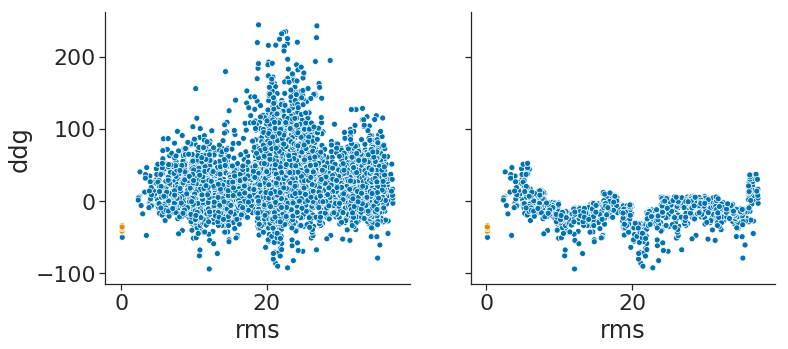

In [10]:
(fig, axs) = plt.subplots(
    ncols=2, sharex=True, sharey=True,
    figsize=[12,5]
)
sns.scatterplot(
    x='rms', y='ddg', data=ddg_df,
    hue='decoy_type', hue_order=['decoy', 'native'],
    ax=axs[0]
)
data = ddg_df[
    ddg_df['description'].isin(top_pdbs_dict[native])
].copy()
sns.scatterplot(
    x='rms', y='ddg', data=data,
    hue='decoy_type', hue_order=['decoy', 'native'],
    ax=axs[1]
)
for i in [0, 1]:
    axs[i].get_legend().remove()
sns.despine()
plt.show()

For each native, do a longer relax (5 repeats) of the top 1000 structures identified from above, and re-compute ddG from the results.

In [11]:
# Make list of XMLs to test
xml_dict = {
    'relax_interface_of_complex' : \
        'scripts/relax_interface_of_complex.xml',
    'relax_interface_of_chainA' : \
        'scripts/relax_interface_of_chainA.xml',
    'relax_interface_of_chainB' : \
        'scripts/relax_interface_of_chainB.xml',
}

# Cycle through energy functions and natives and score
# silent files from each native
relaxscript = 'MonomerDesign2019'
top1000_relax_dir = f'{resultsdir}/top1000_relax_dir/'
e_functions = ['beta_nov16', 'HH_run23A_step384']
for e_function in e_functions:
    
    # Get info for energy function
    (weights, flags, extra_args) = e_functions_dict[e_function]
    
    for native in ['2AJF']:

        # Get the path to the native xtal
        native_xtal = f'data/natives/{native}_bound_native.pdb'

        # Make a list of silent files
        digs_relax_dir = f'{resultsdir}/global_docks/{native}/digs_relax/'
        split_silent_files = glob.glob(os.path.join(
            digs_relax_dir,
            'top1000_split_silent_files/',
            '*'
        ))
        print(native, len(split_silent_files), e_function)

        # Define output directory for energy function
        output_dir = os.path.join(
            top1000_relax_dir,
            e_function + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Relax each file with each protocol
        for input_silent_file in split_silent_files:
            silent_id = os.path.basename(input_silent_file)
            for xml_name in xml_dict:

                # Assemble command
                xml = xml_dict[xml_name]
                output_prefix = os.path.join(
                    output_dir,
                    f'{native}_{silent_id}_{xml_name}'
                )
                cmd = ' '.join([
                    '~/Rosetta/main/source/bin/rosetta_scripts.default.linuxgccrelease',
                    f'-parser:protocol {xml}',
                    '-parser:script_vars',
                    f'wts={weights}',
                    f'relaxscript={relaxscript}',
                    f'-in:file:silent {input_silent_file}',
                    '-in:file:silent_struct_type binary',
                    f'-score:weights {weights}',
                    '-crystal_refine true',
                    f'-in:file:native {native_xtal}',
                    f'-out:prefix {output_dir}',
                    '-out:file:renumber_pdb true',
                    f'-out:file:scorefile {output_prefix}.sc',
                    f'-out:file:silent {output_prefix}.out',
                    '-silent_read_through_errors',
                    '-mute all'
                ])
                for extra_arg in extra_args:
                    cmd += f' {extra_arg}'
                if flags:
                    cmd += f' @{flags}'

                # Submit job
                sbatch_file_name = f'{output_prefix}.sbatch'
                if not os.path.isfile(sbatch_file_name):
                    design_utils.WriteSbatchFile(
                        sbatch_file_name,
                        command=cmd,
                        queue_type='medium',
                        memory='2g'
                    )
                    ! sbatch {sbatch_file_name}

2AJF 20 beta_nov16
2AJF 20 HH_run23A_step384


Read in scores from longer relax

In [12]:
native = '2AJF'
e_function = 'beta_nov16'
f_ids = ['complex', 'chainA', 'chainB']

# Read in data from different relax jobs
n_fs = 0
for f_id in f_ids:

    # Make a list of score files
    score_fs = glob.glob(os.path.join(
        resultsdir,
        'top1000_relax_dir',
        e_function,
        f'{native}_*_{f_id}.sc'
    ))
    n_fs += len(score_fs)
    if len(score_fs) == 0:
        continue

    # Read in data
    dfs = []
    for f in score_fs:
        df = pandas.read_csv(f, skiprows=1, sep='\s+')
        dfs.append(df)
    df = pandas.concat(dfs, sort=False)
    if f_id == 'complex':
        ddg_df = df.copy()
    else:
        df[f_id] = df['total_score']
        ddg_df = ddg_df.merge(
            df[[f_id, 'description']],
            on='description', how='inner'
        )
#     if len(ddg_df) < 1000:
#         continue
# if n_fs == 0:
#     continue

ddg_df['native'] = native

# Identify relaxed natives
ddg_df['decoy_type'] = ddg_df['description'].apply(
    lambda x: 'native' if 'xtal' in x else 'decoy'
)
ddg_df.sort_values('decoy_type', inplace=True)
ddg_df['rms'] = ddg_df['rmsd']
ddg_df['native'] = native
ddg_df['pdb'] = ddg_df['description'].apply(os.path.basename)

# Compute ddg from the total score of the relaxed complex
# compared to the total score of each chain relaxed on its own
ddg_df['ddg'] = \
    ddg_df['total_score'] - ddg_df['chainA'] - ddg_df['chainB']
#ddg_dfs.append(ddg_df)

print(len(ddg_df))

399


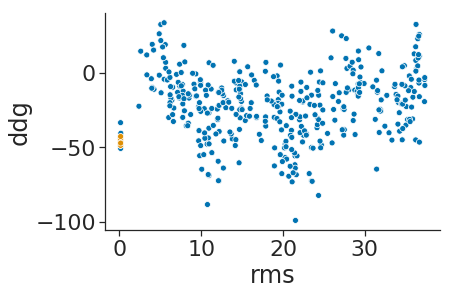

In [13]:
sns.scatterplot(
    x='rms', y='ddg', data=ddg_df,
    hue='decoy_type', hue_order=['decoy', 'native']
)
plt.legend().remove()
sns.despine()
plt.show()

In [14]:
boinc_ddg_df = pandas.read_csv(
    'results/silent_files_for_optE_ddg_noS/2AJF.sc', sep='\s+'
)
boinc_ddg_df['pdb'] = \
    boinc_ddg_df['pdb'].str.extract(r'(HKH_.+chain_[AB]_\d+)_.+')
boinc_ddg_df[['ddg', 'pdb', 'rms']].head()

,ddg,pdb,rms
0,-53.980,HKH_2021_2AJF_run_1_complex.310_chain_B_5,14.226
1,-52.525,HKH_2021_2AJF_run_1_complex.843_chain_B_12,25.503
2,-52.397,HKH_2021_2AJF_run_2_complex.843_chain_B_5,25.536
3,-51.992,HKH_2021_2AJF_run_1_complex.123_chain_B_18,19.883
4,-51.410,HKH_2021_2AJF_run_2_complex.106_chain_B_24,20.068


In [15]:
df = ddg_fp_df.merge(
    ddg_df, on='pdb', suffixes=['_1', '_5'], how='inner'
)
df['pdb'] = df['pdb'].str.extract(r'(HKH_.+chain_[AB]_\d+)_.+')
print(len(df))
df[['ddg_5', 'pdb', 'rms_5']].head()

399


,ddg_5,pdb,rms_5
0,-19.805,NaN,13.364
1,4.673,NaN,34.833
2,-11.705,HKH_2021_2AJF_run_1_complex.471_chain_B_17,10.525
3,-35.994,HKH_2021_2AJF_run_1_complex.443_chain_B_4,22.239
4,-31.288,HKH_2021_2AJF_run_1_complex.464_chain_B_12,31.272


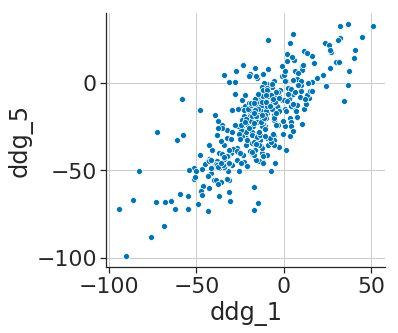

In [16]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
metric = 'ddg'
sns.scatterplot(x=f'{metric}_1', y=f'{metric}_5', data=df, ax=ax)
ax.set_aspect('equal', adjustable='box')
ax.grid()
sns.despine()
plt.show()

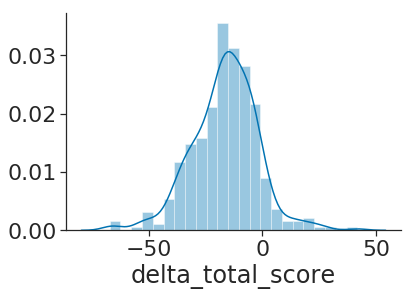

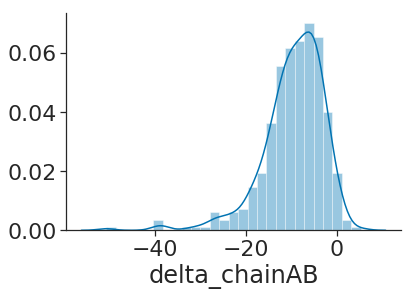

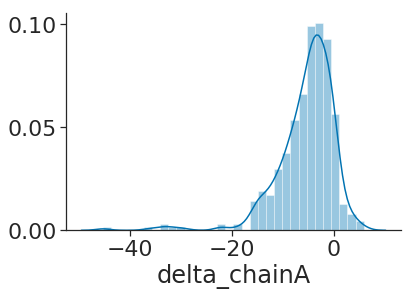

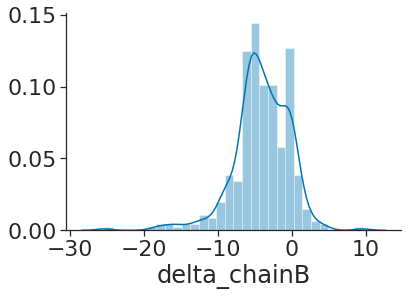

In [90]:
df['chainAB_1'] = df['chainA_1'] + df['chainB_1']
df['chainAB_5'] = df['chainA_5'] + df['chainB_5']
for metric in ['total_score', 'chainAB', 'chainA', 'chainB']:
    df[f'delta_{metric}'] = df[f'{metric}_5'] - df[f'{metric}_1']
    sns.distplot(df[f'delta_{metric}'])
    sns.despine()
    plt.show()

In [91]:
ddg_df.sort_values('ddg', inplace=True)
ddg_df[['ddg', 'rms', 'total_score', 'pdb']].head()

,ddg,rms,total_score,pdb
181,-98.983,21.517,2238.588,HKH_2021_2AJF_run_1_complex.158_chain_B_4_0001...
185,-88.337,10.756,2472.700,HKH_2021_2AJF_run_1_complex.1985_chain_B_4_000...
178,-82.259,24.338,2248.510,HKH_2021_2AJF_complex.865_0001_0001
1,-73.150,21.110,1864.298,HKH_2021_2AJF_run_1_complex.10_chain_B_2_0001_...
304,-72.799,23.559,1933.696,HKH_2021_2AJF_run_1_complex.261_chain_B_1_0001...


In [58]:
ddg_df['pdb'].iloc[0]

'HKH_2021_2AJF_run_1_complex.158_chain_B_4_0001_0001'

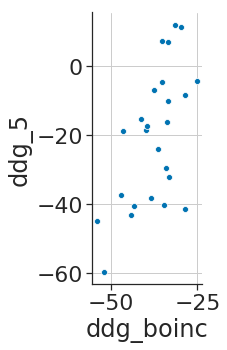

In [100]:
boinc_ddg_df['ddg_boinc'] = boinc_ddg_df['ddg']
digs_ddg_df = df.copy()
digs_ddg_df.dropna(subset=['pdb'], inplace=True)
data = digs_ddg_df.merge(boinc_ddg_df, on='pdb', how='inner')
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
metric = 'ddg'
sns.scatterplot(x=f'{metric}_boinc', y=f'{metric}_5', data=data, ax=ax)
ax.set_aspect('equal', adjustable='box')
ax.grid()
sns.despine()
plt.show()

In [99]:
digs_ddg_df.dropna?

To do
* correlate scores between short and long relaxes

* start submitting decoys to boinc for validation